In [1]:
import pandas as pd
import numpy as np
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [2]:
# Load Tournament results and filter to year > 2008 (oldest moneyline data)
tournament_compact_results_df = pd.read_csv("../data//Kaggle-Data/MDataFiles_Stage1/MNCAATourneyCompactResults.csv")
tournament_compact_results_df = tournament_compact_results_df[tournament_compact_results_df['Season'] >= 2008]

moneyline_df = pd.read_csv("../data/Pre-Processed-Data/CleanedMoneylineData.csv",index_col=0)

In [3]:
tournament_compact_results_df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
1456,2008,134,1291,69,1164,60,N,0
1457,2008,136,1181,71,1125,70,N,0
1458,2008,136,1242,85,1340,61,N,0
1459,2008,136,1243,80,1425,67,N,0
1460,2008,136,1266,74,1246,66,N,0


In [4]:
moneyline_df.head()

,Season,DayNum,TeamID,Moneyline
0,2008,0,1263,200.0
1,2008,0,1350,-240.0
2,2008,0,1404,13000.0
3,2008,0,1272,-39000.0
4,2008,1,1205,-160.0


In [5]:
winner_moneylines = pd.merge(tournament_compact_results_df, moneyline_df, how='left', 
                             left_on=['Season','DayNum','WTeamID'], 
                             right_on = ['Season','DayNum','TeamID'])[["Season", "DayNum", "WTeamID", "LTeamID","Moneyline"]]

winner_moneylines.rename(columns = {"Moneyline": "WMoneyline"}, inplace = True)

In [14]:
tournament_moneyline_df = pd.merge(winner_moneylines, moneyline_df, how='left', 
                             left_on=['Season','DayNum','LTeamID'], 
                             right_on = ['Season','DayNum','TeamID'])[["Season", "DayNum", "WTeamID", "LTeamID","WMoneyline","Moneyline"]]

tournament_moneyline_df.rename(columns = {"Moneyline": "LMoneyline"}, inplace = True)

tournament_moneyline_df.head()

,Season,DayNum,WTeamID,LTeamID,WMoneyline,LMoneyline
0,2008,134,1291,1164,-375.0,315.0
1,2008,136,1181,1125,-4500.0,2250.0
2,2008,136,1242,1340,-5000.0,2500.0
3,2008,136,1243,1425,140.0,-160.0
4,2008,136,1266,1246,-275.0,235.0


In [15]:
tournament_moneyline_df.isna().sum()

Season        0
DayNum        0
WTeamID       0
LTeamID       0
WMoneyline    0
LMoneyline    3
dtype: int64

In [21]:
# For now, drop NAs
tournament_moneyline_df = tournament_moneyline_df.dropna()

#### Determining implied probability

In [35]:
def calc_implied_p(moneyline):
    if moneyline < 0:
        return (-1*(moneyline)) / (-1*(moneyline) + 100)
    else:
        return 100 / (moneyline + 100)
    
def calc_net_payout(moneyline, amount_bet = 1):
    if moneyline < 0:
        return -amount_bet*(100/moneyline)
    else:
        return amount_bet*(moneyline/100)


In [23]:
tournament_probability_df = tournament_moneyline_df
tournament_probability_df["WTeam_Win%"] = tournament_probability_df["WMoneyline"].apply(calc_implied_p)
tournament_probability_df["LTeam_Win%"] = tournament_probability_df["LMoneyline"].apply(calc_implied_p)

tournament_probability_df.head()

,Season,DayNum,WTeamID,LTeamID,WMoneyline,LMoneyline,WTeam_Win%,LTeam_Win%
0,2008,134,1291,1164,-375.0,315.0,0.789474,0.240964
1,2008,136,1181,1125,-4500.0,2250.0,0.978261,0.042553
2,2008,136,1242,1340,-5000.0,2500.0,0.980392,0.038462
3,2008,136,1243,1425,140.0,-160.0,0.416667,0.615385
4,2008,136,1266,1246,-275.0,235.0,0.733333,0.298507


#### Strategy 1: Always bet 1 unit on favorite

In [72]:
def bet_favorite(df):
    initial_investment = len(df.index) # 1 unit for every game
    running_balance = initial_investment
    for idx, row in df.iterrows():
        if row["WTeam_Win%"] > row["LTeam_Win%"]: # The favorite was the winning team 
            running_balance += calc_net_payout(row["WMoneyline"])
        else: # The favorite was the losing team
            running_balance -= 1

    bet_favorite_ROI = (running_balance - initial_investment)/initial_investment  
    return bet_favorite_ROI

#### Strategy 2: Always bet 1 unit on underdog

In [84]:
def bet_underdog(df):
    initial_investment = len(df.index) # 1 unit for every game
    running_balance = initial_investment
    for idx, row in df.iterrows():
        if row["WTeam_Win%"] < row["LTeam_Win%"]: # The underdog was the winning team 
            running_balance += calc_net_payout(row["WMoneyline"])
        else: # The favorite was the losing team
            running_balance -= 1

    bet_underdog_ROI = (running_balance - initial_investment)/initial_investment 
    return bet_underdog_ROI

#### Strategy 3: Bet 1 unit in alignment with random choice based on implied win%

In [94]:
def bet_mixed(df, n_iter=30):
    result_tracker = np.empty(n_iter)
    
    for trial_num in range(n_iter): # Conduct several trials to reduce chance
        
        initial_investment = len(df.index) # 1 unit for every game
        running_balance = initial_investment
        for idx, row in df.iterrows():
            normalized_p_win = row["WTeam_Win%"]/(row["WTeam_Win%"] + row["LTeam_Win%"])
            normalized_p_lose = row["LTeam_Win%"]/(row["WTeam_Win%"] + row["LTeam_Win%"])
            bet_on = np.random.choice(["winner","loser"], p=[normalized_p_win,normalized_p_lose])
            if bet_on == "winner":
                running_balance += calc_net_payout(row["WMoneyline"])
            else:
                running_balance -= 1

        bet_mixed_ROI = (running_balance - initial_investment)/initial_investment 
        
        result_tracker[trial_num] = bet_mixed_ROI
    
    return np.mean(result_tracker)
                                                    

### Strategy comparisson

In [95]:
list_of_years = np.unique(tournament_probability_df["Season"])
favorite_tracker = []
underdog_tracker = []
mixed_tracker = []

for year in list_of_years:
    year_df = tournament_probability_df[tournament_probability_df["Season"] == year]
    favorite_tracker.append(bet_favorite(year_df))
    underdog_tracker.append(bet_underdog(year_df))
    mixed_tracker.append(bet_mixed(year_df))

dummy_ROI_comparisson = pd.DataFrame({"Year": list_of_years, 
                                      "Bet Favorite":favorite_tracker, 
                                      "Bet Underdog":underdog_tracker,
                                      "Bet Mixed":mixed_tracker})

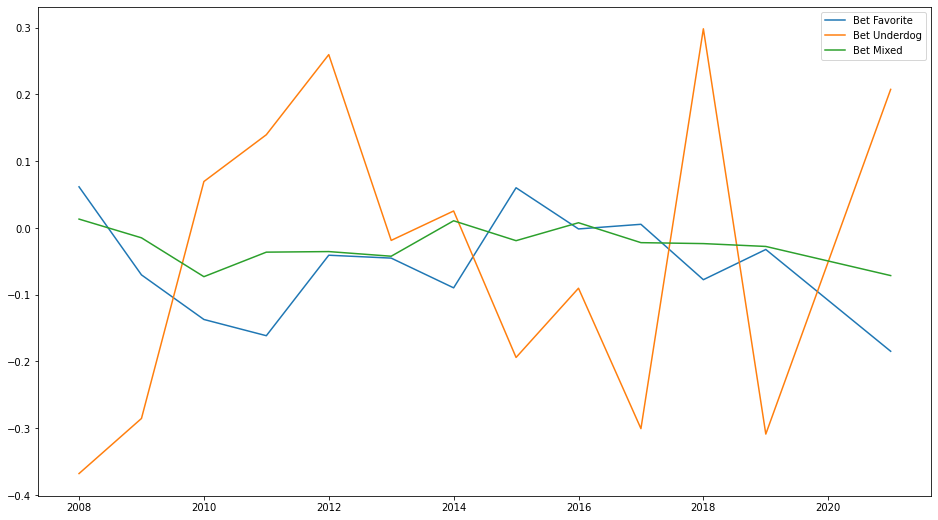

In [96]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 9))

plt.plot(list_of_years, favorite_tracker, label = "Bet Favorite")
plt.plot(list_of_years, underdog_tracker, label = "Bet Underdog")
plt.plot(list_of_years, mixed_tracker, label = "Bet Mixed")
plt.legend()
plt.show()

In [108]:
regular_season_compact_results_df = pd.read_csv("../data//Kaggle-Data/MDataFiles_Stage1/MRegularSeasonCompactResults.csv")
regular_season_compact_results_df = regular_season_compact_results_df[regular_season_compact_results_df['Season'] >= 2008]



In [109]:
winner_moneylines = pd.merge(regular_season_compact_results_df, moneyline_df, how='left', 
                             left_on=['Season','DayNum','WTeamID'], 
                             right_on = ['Season','DayNum','TeamID'])[["Season", "DayNum", "WTeamID", "LTeamID","Moneyline"]]

winner_moneylines.rename(columns = {"Moneyline": "WMoneyline"}, inplace = True)

In [110]:
tournament_moneyline_df = pd.merge(winner_moneylines, moneyline_df, how='left', 
                             left_on=['Season','DayNum','LTeamID'], 
                             right_on = ['Season','DayNum','TeamID'])[["Season", "DayNum", "WTeamID", "LTeamID","WMoneyline","Moneyline"]]

tournament_moneyline_df.rename(columns = {"Moneyline": "LMoneyline"}, inplace = True)

tournament_moneyline_df.head()

,Season,DayNum,WTeamID,LTeamID,WMoneyline,LMoneyline
0,2008,0,1272,1404,-39000.0,13000.0
1,2008,0,1350,1263,-240.0,200.0
2,2008,1,1205,1105,-160.0,140.0
3,2008,1,1246,1146,-7000.0,3000.0
4,2008,1,1272,1350,-10000.0,4000.0


In [111]:
tournament_moneyline_df.isna().sum()

Season            0
DayNum            0
WTeamID           0
LTeamID           0
WMoneyline    19490
LMoneyline    19517
dtype: int64